# Statistical Methods in AI (CSE/ECE 471) - Spring-2020
#  Assignment-1 / **Q3** / Topic: Decision Tree
# Submitted By: VENUGOPAL REDDY MEKA
# Roll No: 2019900065

In [164]:
# Load the required imports
import matplotlib.pyplot as plt
import seaborn as sns

# use matplotlib inline for Jupyter notebook
%matplotlib inline

## Load the classes DecisionTreeNode and DecisionTree ( from q3.py)

In [165]:
"""
Statistical Methods in AI (CSE/ECE 471)
Spring-2020
Assignment-1
Q3
Topic: Decision Tree
Submitted By: VENUGOPAL REDDY MEKA
Roll No: 2019900065
"""

import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import logging.config
from math import sqrt

# Configuration for logging
logging_config = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'standard': {
            'format': '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
            'datefmt': "%Y-%m-%d %H:%M:%S"
        }
    },
    'handlers': {
        'console': {
            'level': 'DEBUG',
            'formatter': 'standard',
            'class': 'logging.StreamHandler',
            'stream': 'ext://sys.stdout',
        }
    },
    'loggers': {
        '': {
            'handlers': ['console'],
            'level': 'INFO'
        },
    }
}
logging.config.dictConfig(logging_config)


class DecisionTreeNode:
    """
    DecisionTreeNode class.
    Uses recursion to create the decision tree nodes
    """

    def __init__(self, min_leaf_size=20):
        """

        :param x:
        :param y:
        :param idxs:
        :param min_leaf:
        """
        self.X = None
        self.y = None
        self.indexes = None
        self.min_leaf_size = min_leaf_size
        self.val = None
        self.split_score = float('inf')
        self.col_index = None
        self.split = None
        self.left = None
        self.right = None

    def fit(self, X, y, indexes):
        """
        Fits the data to the left and right side of the node
        :param X:
        :param y:
        :param indexes:
        :return:
        """
        self.X = X
        self.y = y
        self.indexes = indexes if indexes is not None else np.array(np.arange(len(y)))
        self.val = np.mean(y[self.indexes])
        self.find_best_split()

    def find_best_split(self):
        """
        Finds the best split across all the columns
        :return:
        """
        col_count = self.X.shape[1]
        for col_index in range(col_count):
            self.find_best_split_for_column(col_index)

        if self.is_leaf:
            return

        self.create_branches()

    def create_branches(self):
        """
        Creates the left and right branches from the split
        :return:
        """
        x = self.X.values[self.indexes, self.col_index]

        l_idx = np.nonzero(x <= self.split)[0]
        r_idx = np.nonzero(x > self.split)[0]

        self.left = DecisionTreeNode()
        self.left.fit(self.X, self.y, self.indexes[l_idx])

        self.right = DecisionTreeNode()
        self.right.fit(self.X, self.y, self.indexes[r_idx])

    def find_best_split_for_column(self, col_index):
        """
        Finds the best split for the column
        :param col_index:
        :return:
        """
        x = self.X.values[self.indexes, col_index]

        for r in range(len(self.indexes)):
            lhs = x <= x[r]
            rhs = x > x[r]
            # check if the left or right reached below
            # minimum leaf size
            if rhs.sum() < self.min_leaf_size or \
                    lhs.sum() < self.min_leaf_size:
                continue

            curr_split_score = self.find_split_score(lhs, rhs)
            if curr_split_score < self.split_score:
                self.split_score = curr_split_score
                self.split = x[r]
                self.col_index = col_index

    def find_split_score(self, lhs, rhs):
        """
        Find the weighted average of the standard deviation of the left
        and right values.
        :param lhs:
        :param rhs:
        :return:
        """
        y = self.y[self.indexes]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()

    @property
    def is_leaf(self):
        return self.split_score == float('inf')

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        node = self.left if xi[self.col_index] <= self.split else self.right
        return node.predict_row(xi)


class DecisionTree:
    """
    DecisionTree class - Handles train and predict methods
    """
    def __init__(self):
        """
        Init
        """
        self.logger = logging.getLogger(__name__)
        self.df_train = None
        self.dt_node = DecisionTreeNode()

    def train(self, train_csv):
        """
        Creates train-validation data split and computes the optimal K value
        :param train_csv:
        :return: None
        """
        try:
            if not train_csv:
                raise ValueError("Input train data csv cannot be None")

            # load the csv file
            self.logger.info("Loading the train data into dataframe")
            df = pd.read_csv(train_csv)

            # Extract only the columns with high correlation with the SalePrice
            self.df_train = df[['OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice']]
            X_train = self.df_train.copy()
            y_train = X_train['SalePrice']
            X_train = X_train.drop(columns=['SalePrice'], axis=1)

            self.fit(X_train, y_train)

        except Exception as err:
            self.logger.error("Error occurred while updating the training data ", str(err))

    def predict(self, test_csv):
        """
        Predicts the hand written digits for the 784 dimensional vector's from the test data
        :param test_csv:
        :return: list of predicted digits
        :rtype: List
        """
        try:
            self.logger.info("Loading the test data for prediction")
            df_test = pd.read_csv(test_csv)
            df_test = df_test[['OverallQual', 'GrLivArea', 'GarageCars']]
            self.logger.info("Predicting the results using the decision tree")
            return self.dt_node.predict(df_test.values)

        except Exception as err:
            self.logger.error("Error occurred while doing prediction", str(err))

    def train_validation_split(self, df, validation_size=0.25):
        """
        Split the data into train, validation using the validation_size
        :param validation_size:
        :return: X_train, y_train, X_validate, y_validate
        """
        self.logger.info(f"Splitting the train data to train, validation sets with validation_size: {validation_size}")

        X_train = df.sample(frac=(1 - validation_size), random_state=200)
        y_train = X_train['SalePrice']
        X_validate = df.drop(X_train.index)
        y_validate = X_validate['SalePrice']

        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        X_validate = X_validate.reset_index(drop=True)
        y_validate = y_validate.reset_index(drop=True)

        # Drop the SalePrice column from X_train and X_validate
        X_train = X_train.drop(columns=['SalePrice'], axis=1)
        X_validate = X_validate.drop(columns=['SalePrice'], axis=1)

        return X_train, y_train, X_validate, y_validate

    def fit(self, X, y):
        self.logger.info("Fitting the train data into the decision tree")
        self.dt_node.fit(X, y, np.array(np.arange(len(y))))

    def rmse(self, y_true, y_pred):
        self.logger.info("Computing the root mean square error")
        return sqrt(mean_squared_error(y_true, y_pred))

    def r2_score(self, y_true, y_pred):
        self.logger.info("Computing the r2_score")
        return r2_score(y_true, y_pred)


## Experiments

### Load the train data

In [166]:
dtree_regressor = DecisionTree()
df = pd.read_csv('./Datasets/q3/train.csv')
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,99.0,12099,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,354000
1,2,20,RL,89.0,13214,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,378500
2,3,120,RM,32.0,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,153500
3,4,160,FV,30.0,3000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,173733
4,5,20,RL,NaN,6897,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,127000
5,6,160,RL,36.0,2628,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,175500
6,7,120,RM,32.0,4500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,162000
7,8,60,RL,NaN,9636,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,178000
8,9,20,RL,68.0,9571,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,129000
9,10,20,RL,70.0,7535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnWw,Shed,480,6,2007,WD,Normal,120000


### Explore the data

In [167]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1000.000000,1000.000000,825.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,993.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,55.435000,71.310303,10780.917000,6.118000,5.581000,1971.312000,1984.879000,107.338369,462.870000,...,90.234000,47.412000,22.470000,2.650000,16.682000,3.452000,43.394000,6.318000,2007.793000,182854.640000
std,288.819436,41.477779,24.185834,11388.573501,1.406433,1.112959,29.862995,20.604536,183.872754,470.499278,...,122.730918,68.156082,62.770831,24.189639,58.409422,44.995403,526.413324,2.686651,1.329631,82290.996386
min,1.000000,20.000000,21.000000,1300.000000,1.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,250.750000,20.000000,60.000000,7587.250000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,500.500000,50.000000,70.000000,9500.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,403.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163950.000000
75%,750.250000,70.000000,81.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,170.000000,740.000000,...,165.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,1000.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,736.000000,547.000000,552.000000,407.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


There are 38 columns, some are categorical and some numerical. Out of 38 columns, we need to determine which parameter more impact on the SalePrice. To achieve that we need to find the correlation between the SalePrice and other parameters

#### Find the correlation between columns

In [168]:
df_corr_mat = df.corr()

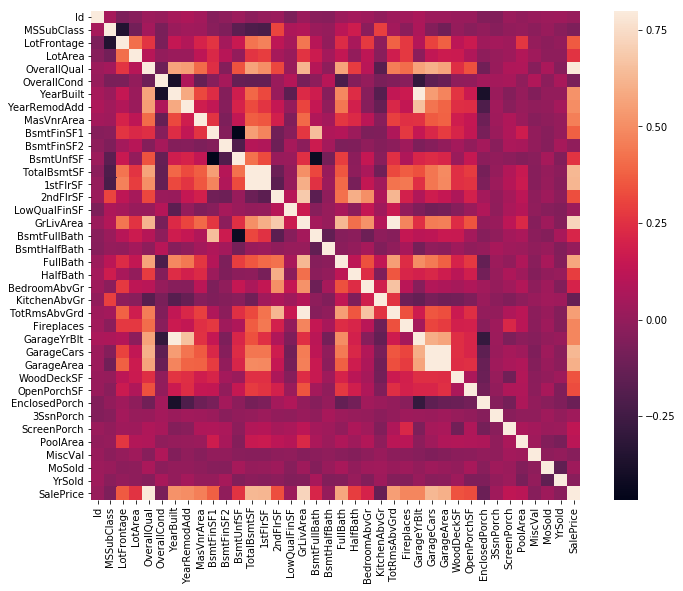

In [169]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr_mat, vmax=.8, square=True);

#### Find the parameters with highest correlation to the SalesPrice

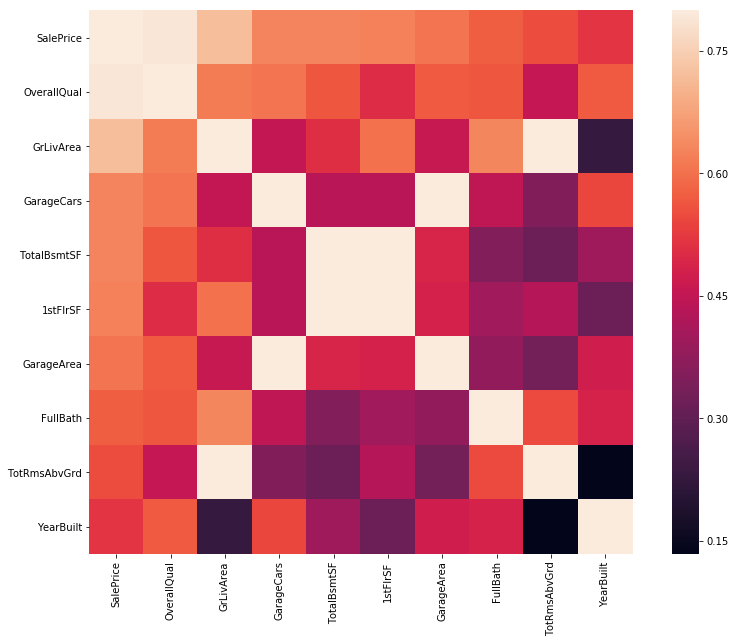

In [170]:
# Find 10 variables with highest correlation to the salesprice
n = 10
cols = df_corr_mat.nlargest(n, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(df[cols].corr(), vmax=.8, square=True);

#### Columns with highest correlation to the SalePrice

In [171]:
print(cols)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
       '1stFlrSF', 'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


### Data Preparation

#### Check for missing values

In [172]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,994,0.994
MiscFeature,964,0.964
Alley,950,0.950
Fence,808,0.808
FireplaceQu,464,0.464
LotFrontage,175,0.175
GarageCond,53,0.053
GarageType,53,0.053
GarageYrBlt,53,0.053
GarageFinish,53,0.053


There are no missing values in columns ***[SalePrice, OverallQual, GrLivArea, GarageCars, TotalBsmtSF, 1stFlrSF, GarageArea, FullBath, TotRmsAbvGrd, YearBuilt]*** with high correlation to the SalesPrice. So ignoring the missing values in other columns.

To keep it simple, We consider the first 3 columns with highest correlation with SalesPrice for decision tree regression.

In [173]:
df_corr_mat.nlargest(4, 'SalePrice')['SalePrice']

SalePrice      1.000000
OverallQual    0.791954
GrLivArea      0.721662
GarageCars     0.629550
Name: SalePrice, dtype: float64

Excluding SalePrice from the above list, We consider the first 3 columns ***[OverallQual, GrLivArea, GarageCars]*** with highest correlation with SalesPrice for decision tree regression.

### Split the train data to train and validations sets

In [174]:
# Filter the highest correlated columns in a seperate dataframe
df_train = df[['OverallQual', 'GrLivArea', 'GarageCars', 'SalePrice']]
# Split into train and validation sets with validation size 0.25
X_train, y_train, X_validate, y_validate = dtree_regressor.train_validation_split(df_train, 0.25)

2020-01-31 12:31:34 - INFO - __main__ - Splitting the train data to train, validation sets with validation_size: 0.25


In [175]:
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_validate: {X_validate.shape}")
print(f"Shape of y_validate: {y_validate.shape}")
X_train.head()

Shape of df_train: (1000, 4)
Shape of X_train: (750, 3)
Shape of y_train: (750,)
Shape of X_validate: (250, 3)
Shape of y_validate: (250,)


,OverallQual,GrLivArea,GarageCars
0,3,1733,2
1,6,1117,2
2,6,1382,2
3,6,1644,2
4,7,1501,2


In [176]:
X_validate.head()

,OverallQual,GrLivArea,GarageCars
0,8,2468,3
1,6,1337,2
2,6,1204,2
3,6,1593,2
4,4,1040,2


### Model Creation 

The score used for spliting the weighted average of the 
We’re going to create our split such that it has as low standard deviation as possible. We find the split that minimizes the weighted averages of the standard deviations which is equivalent to minimizing RMSE.

In [177]:
dtree_regressor.fit(X_train, y_train)

2020-01-31 12:31:34 - INFO - __main__ - Fitting the train data into the decision tree


### Model Evaluation

In [178]:
# Perform the prediction on the validation set
y_pred = dtree_regressor.dt_node.predict(X_validate.values)

#### Compute Metrics

#### Root Mean Square Error (RMSE)

In [179]:
rmse = dtree_regressor.rmse(y_true=y_validate, y_pred=y_pred)
print(rmse)

2020-01-31 12:32:14 - INFO - __main__ - Computing the root mean square error
39384.79802942284


#### R2 Score

In [180]:
r2_score_val = dtree_regressor.r2_score(y_true=y_validate, y_pred=y_pred)
print(r2_score_val)

2020-01-31 12:32:14 - INFO - __main__ - Computing the r2_score
0.739413211771351


#### Mean Square Error (MSE)

In [181]:
mse = mean_squared_error(y_true=y_validate, y_pred=y_pred)
print(mse)

1551162315.8184292


## Decision Tree using  scikit-learn

In [182]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object 
sklearn_regressor = DecisionTreeRegressor(random_state = 0)

# fit the regressor with X and Y data
sklearn_regressor.fit(X_train, y_train)

y_pred_sklearn = sklearn_regressor.predict(X_validate)

### Compute metrics for sklearn model

#### Root Mean Square Error (RMSE) - sklearn model

In [183]:
rmse = dtree_regressor.rmse(y_true=y_validate, y_pred=y_pred_sklearn)
print(rmse)

2020-01-31 12:32:14 - INFO - __main__ - Computing the root mean square error
41190.50078794597


#### R2 Score - sklearn model

In [184]:
r2_score_val = dtree_regressor.r2_score(y_true=y_validate, y_pred=y_pred_sklearn)
print(r2_score_val)

2020-01-31 12:32:14 - INFO - __main__ - Computing the r2_score
0.714970840641622


#### Mean Square Error (MSE) - sklearn model

In [185]:
mse = mean_squared_error(y_true=y_validate, y_pred=y_pred_sklearn)
print(mse)

1696657355.1617777


*From the performance metrics - RMSE, r2 score, MSE the custom decision tree model and decision tree model created using scikit-learn has more or less similar performance*

## Performance on the test dataset

### Load the test dataset

In [186]:
df_test = pd.read_csv('./Datasets/q3/test.csv')
df_test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1001,20,RL,80.0,9920,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1,1002,20,RL,60.0,7200,Pave,NaN,Reg,Bnk,AllPub,...,0,0,NaN,MnPrv,NaN,0,1,2008,WD,Normal
2,1003,20,RL,93.0,9382,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
3,1004,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal
4,1005,60,RL,65.0,15426,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal
5,1006,20,RL,NaN,8475,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal
6,1007,20,RM,90.0,7407,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal
7,1008,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml
8,1009,120,RL,34.0,5381,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
9,1010,80,RL,80.0,8816,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [187]:
### Extract the required columns required by the decision tree
df_test = df_test[['OverallQual', 'GrLivArea', 'GarageCars']]
df_test.head()

,OverallQual,GrLivArea,GarageCars
0,5,1063,1
1,5,780,1
2,7,1479,2
3,6,1056,2
4,6,1764,2


### Predict using the custom decision tree model

In [188]:
y_test_pred = dtree_regressor.dt_node.predict(df_test.values)

### Predict using the decision tree model created using scikit-learn

In [189]:
y_test_pred_sklearn = sklearn_regressor.predict(df_test.values)

### Compute metrics for test dataset

In [190]:
# Load the test labels
test_labels = list()
with open("./Datasets/q3/test_labels.csv") as f:
    for line in f:
        test_labels.append(float(line.split(',')[1]))

#### Actual vs Predicted (Custom Decision Tree Model)

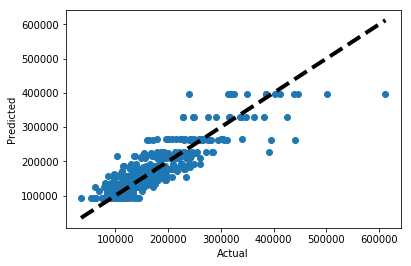

In [191]:
fig, ax = plt.subplots()
ax.scatter(test_labels, y_test_pred)
ax.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Actual vs Predicted (Sklearn Decision Tree Model)

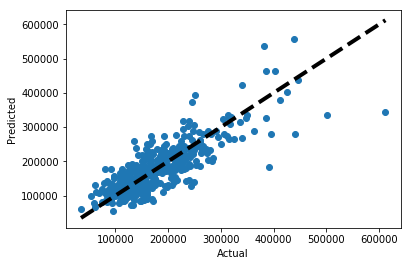

In [192]:
fig, ax = plt.subplots()
ax.scatter(test_labels, y_test_pred_sklearn)
ax.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

#### Root Mean Square Error (RMSE)

**Custom Decision Tree**

In [193]:
rmse_dtree = dtree_regressor.rmse(y_true=test_labels, y_pred=y_test_pred)
print(rmse_dtree)

2020-01-31 12:32:15 - INFO - __main__ - Computing the root mean square error
37162.27319480204


**Sklearn Decision Tree**

In [194]:
rmse_sklearn = dtree_regressor.rmse(y_true=test_labels, y_pred=y_test_pred_sklearn)
print(rmse_sklearn)

2020-01-31 12:32:15 - INFO - __main__ - Computing the root mean square error
43695.39549510602


#### R2 Score

**Custom Decision Tree**

In [195]:
r2_score_dtree = dtree_regressor.r2_score(y_true=test_labels, y_pred=y_test_pred)
print(r2_score_dtree)

2020-01-31 12:32:15 - INFO - __main__ - Computing the r2_score
0.7386782406707768


In [196]:
r2_score_sklearn = dtree_regressor.r2_score(y_true=test_labels, y_pred=y_test_pred_sklearn)
print(r2_score_sklearn)

2020-01-31 12:32:15 - INFO - __main__ - Computing the r2_score
0.6387212819668275


#### Mean Square Error (MSE)

**Custom Decision Tree**

In [197]:
mse_dtree = mean_squared_error(y_true=test_labels, y_pred=y_test_pred)
print(mse_dtree)

1381034549.005102


**Sklearn Decision Tree**

In [198]:
mse_sklearn = mean_squared_error(y_true=test_labels, y_pred=y_test_pred_sklearn)
print(mse_sklearn)

1909287587.4737318


### Conclusion

The performance of the custom decision tree model is slightly better than the sklearn decision tree model